<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Vehicle Insurance Fraud Detection

## Part III: Deployment of Modelling 

In Part II with the evaluation of different models, our criteria matrix include `precision` and `ROC_AUC`curve. We found out that XGBoost has the best rating after applying `threshold` and `weightage`. This can also be seen within the confusion matrix, that out of all the models, XGBoost has the lowest type I error which is the predicted value is positive but false. We will want to minimised our false positive in the confusion matrix as it shows the model incorrectly classifying a non-fraudulent transaction as fraudulent. This can have an impact for the business as it is may result in blocking legitmate transactions and frustrating customers.

In this notebook, we will be training the chosen model, `XGBoost` with the tuned parameters,threshold and weightage for our deployment into production. 


`XGBoost` within the community is known to be one of the more advanced boosting models which do not require features to be one hot encoded and also can handle missing values. Hence we will be skipping the preprocessing steps of ordinal and One-Hot Encoding. 

1. https://developer.nvidia.com/blog/categorical-features-in-xgboost-without-manual-encoding/#:~:text=Now%2C%20XGBoost%201.7%20includes%20an,without%20having%20to%20manually%20encode
2. https://docs.h2o.ai/driverless-ai/1-10-lts/docs/userguide/missing-values-handling.html#:~:text=¶-,LightGBM%2C%20XGBoost%2C%20RuleFit,for%20missing%20values%20during%20scoring

## Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as ss
from scipy.stats import f_oneway, norm
from collections import Counter
import math
from itertools import product


import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, recall_score, precision_score

from xgboost import XGBClassifier


from joblib import dump

## Import Datasets

In [2]:
df = pd.read_csv('./datasets/cleaned_fraud_oracle.csv')

## Dropping unncessary features

In [3]:
#Month,Make, AccidentArea, Sex, Age, Fault, VehicleCategory,FraudFround_P,Deductible,PastNumberOfClaims
#AgeOfPolicyHolder, PoliceReportFiled,AgentType,NumberOfSuppliments,AddressChange_Claim,Year,BasePolicy
#AgeOfVehicle

df = df[['Month', 'Make', 'AccidentArea', 'Sex', 'Age', 'Fault', 'VehicleCategory', 
         'FraudFound_P', 'Deductible', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 
         'PoliceReportFiled', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 
         'BasePolicy', 'AgeOfVehicle']]

In [4]:
df.shape

(15419, 17)

NameError: name 'FraudFound_P' is not defined

### Checking for null values or duplicates 

In [5]:
df.isnull().sum()

Month                  0
Make                   0
AccidentArea           0
Sex                    0
Age                    0
Fault                  0
VehicleCategory        0
FraudFound_P           0
Deductible             0
PastNumberOfClaims     0
AgeOfPolicyHolder      0
PoliceReportFiled      0
AgentType              0
NumberOfSuppliments    0
AddressChange_Claim    0
BasePolicy             0
AgeOfVehicle           0
dtype: int64

In [6]:
df.duplicated().sum()

270

In [7]:
df = df.drop_duplicates(keep = 'first')
df.duplicated().sum()
print(df.shape)

(15149, 17)


In [8]:
for column in df:
    if column == 'PolicyNumber':
        pass
    else:
        print(column)
        print(sorted(df[column].unique()))
        print()

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep']

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW']

AccidentArea
['Rural', 'Urban']

Sex
['Female', 'Male']

Age
[16.0, 16.5, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0]

Fault
['Policy Holder', 'Third Party']

VehicleCategory
['Sedan', 'Sport', 'Utility']

FraudFound_P
[0, 1]

Deductible
[300, 400, 500, 700]

PastNumberOfClaims
['1', '2 to 4', 'more than 4', 'none']

AgeOfPolicyHolder
['16 to 17', '18 to 20', '21 to 25', '26 t

In [9]:
df.columns

Index(['Month', 'Make', 'AccidentArea', 'Sex', 'Age', 'Fault',
       'VehicleCategory', 'FraudFound_P', 'Deductible', 'PastNumberOfClaims',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'BasePolicy',
       'AgeOfVehicle'],
      dtype='object')

## Preprocessing

In [10]:
# assuming your DataFrame is called `df`
object_cols = df.select_dtypes(include=['object'])

# change the dtype of each object column to categorical
for col in object_cols:
    df[col] = df[col].astype('category')

# verify the dtype has been changed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15149 entries, 0 to 15418
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Month                15149 non-null  category
 1   Make                 15149 non-null  category
 2   AccidentArea         15149 non-null  category
 3   Sex                  15149 non-null  category
 4   Age                  15149 non-null  float64 
 5   Fault                15149 non-null  category
 6   VehicleCategory      15149 non-null  category
 7   FraudFound_P         15149 non-null  int64   
 8   Deductible           15149 non-null  int64   
 9   PastNumberOfClaims   15149 non-null  category
 10  AgeOfPolicyHolder    15149 non-null  category
 11  PoliceReportFiled    15149 non-null  category
 12  AgentType            15149 non-null  category
 13  NumberOfSuppliments  15149 non-null  category
 14  AddressChange_Claim  15149 non-null  category
 15  BasePolicy         

## Train Test Split

In [11]:
X = df.drop(columns = 'FraudFound_P')
y = df['FraudFound_P']

In [12]:
X_train,X_test, y_train, y_test = train_test_split(X,y, random_state= 42, stratify=y, test_size= 0.3)

## Model

### XGBoost

In [13]:
def modeltype(training_data, test_data,model_1,param_grid):
    
    # Initialize classifier model
    classifier = model_1
    
    #Gridsearch CV
    skf = RepeatedStratifiedKFold(n_splits=2)
    gs = GridSearchCV(classifier, param_grid=param_grid, scoring='precision', cv=skf)
    gs.fit(X_train, y_train)


    # Predict the classes on the testing data
    y_pred_train = gs.predict(X_train)
    y_pred_test = gs.predict(X_test) 

    
    # Calculate the accuracy score
    accuracy_train_score = accuracy_score(y_train, y_pred_train)
    accuracy_test_score = accuracy_score(y_test,y_pred_test)


    # Print the scores
    print('------------------------------------------------------------')
    print(f"Train Score: {round(accuracy_train_score,4)}")
    print(f"Test Score: {round(accuracy_test_score,4)}")
    print('------------------------------------------------------------')
    print(classification_report(y_test, y_pred_test))
    print('------------------------------------------------------------')
    print("Best parameters: ", gs.best_params_)
    print('------------------------------------------------------------')
    print("Best score: ", gs.best_score_)
    
    ig, ax = plt.subplots(1,2, figsize=(10,5))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_test)
    ax[1].plot(fpr,tpr, label="AUC="+str(auc))
    ax[1].set_title('ROC AUC')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].legend(loc=4)
    plt.show()
    
    feat_importances = pd.Series(gs.best_estimator_.feature_importances_, index=X_train.columns)
    feat_importances.sort_values(ascending=False).head(10).plot(kind='barh');

    
    

    return gs

def find_best_tresh(pred_proba, y_test):
    df_res = pd.DataFrame({'prob':pred_proba})
    cut_off = [0.0,0.05, 0.1, 0.15 , 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    f1_result = []
    for i in cut_off:
        df_res['final_predicted'] = df_res['prob'].map( lambda x: 1 if x > i else 0)
        f1_result.append(roc_auc_score(y_test, df_res['final_predicted']))
    df_res2 = pd.DataFrame({'cut_off':cut_off, 'f1_score':f1_result})
    best_tresh = df_res2.sort_values('f1_score', ascending=False).head(1)['cut_off'].values[0]
    y_pred_thresh = (y_pred >= best_tresh).astype('float')
    print('Best Threshold :', best_tresh)
    metric_result(y_test, y_pred_thresh)
    
def metric_result(y_test, y_pred):
    print("F1 Score : ",f1_score(y_test, y_pred, average='binary'))
    print("Recall Score : ",recall_score(y_test, y_pred))
    print("Precision Score : ",precision_score(y_test, y_pred))

    ig, ax = plt.subplots(1,2, figsize=(10,5))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    ax[1].plot(fpr,tpr, label="AUC="+str(auc))
    ax[1].set_title(f'ROC AUC')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].legend(loc=4)
    plt.show()

------------------------------------------------------------
Train Score: 0.9868
Test Score: 0.8981
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4271
           1       0.17      0.18      0.18       274

    accuracy                           0.90      4545
   macro avg       0.56      0.56      0.56      4545
weighted avg       0.90      0.90      0.90      4545

------------------------------------------------------------
Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'scale_pos_weight': 25}
------------------------------------------------------------
Best score:  0.1915279394483465


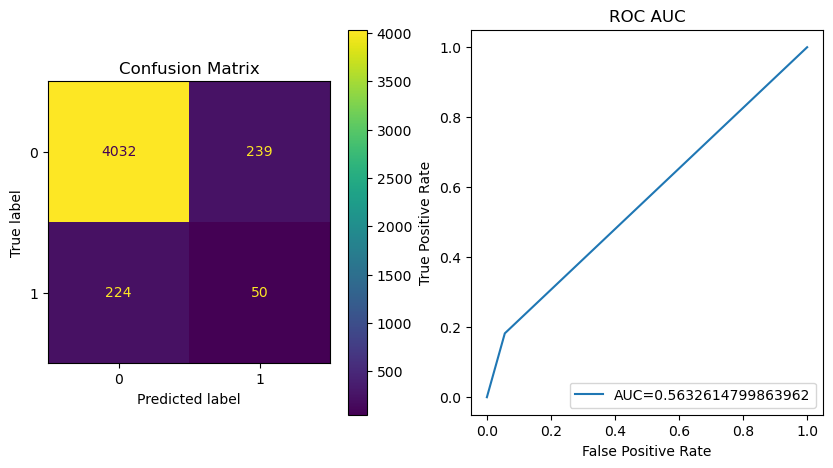

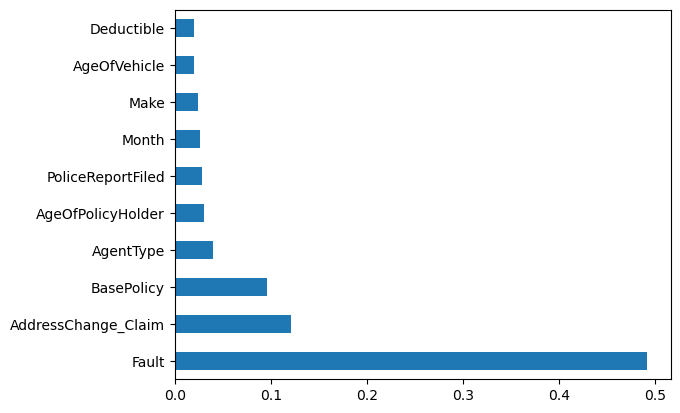

In [14]:
# Define the XGBClassifier
xgb = XGBClassifier(
    tree_method="hist", 
    enable_categorical="True", 
    max_cat_to_onehot=1,
    use_label_encoder=False, 
    objective= 'binary:logistic',
    eval_metric='auc'
)

# Define parameter grid
params = {
    'max_depth':[7],        #[3, 5, 7],
    'min_child_weight':[1],  #[1, 3, 5],
    'learning_rate': [0.1],  #[0.1, 0.01, 0.001],
    'n_estimators': [500],   #[100, 500, 1000],
    'scale_pos_weight': [25]
}

xgb_model = modeltype(X_train,X_test,xgb, params)

Best Threshold : 0.05
F1 Score :  0.23510971786833854
Recall Score :  0.5474452554744526
Precision Score :  0.1497005988023952


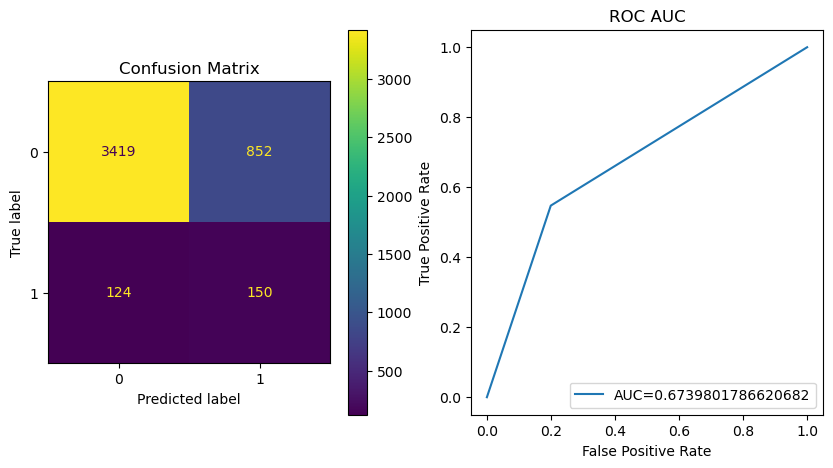

In [15]:
y_pred = xgb_model.predict_proba(X_test)[:, 1].tolist()
find_best_tresh(y_pred, y_test)

### Final Model after applying threshold

------------------------------------------------------------
Train Score: 0.8465
Test Score: 0.7853
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      4271
           1       0.15      0.55      0.24       274

    accuracy                           0.79      4545
   macro avg       0.56      0.67      0.56      4545
weighted avg       0.92      0.79      0.84      4545

------------------------------------------------------------
Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'scale_pos_weight': 25}
------------------------------------------------------------
Best score:  0.18090582213005135


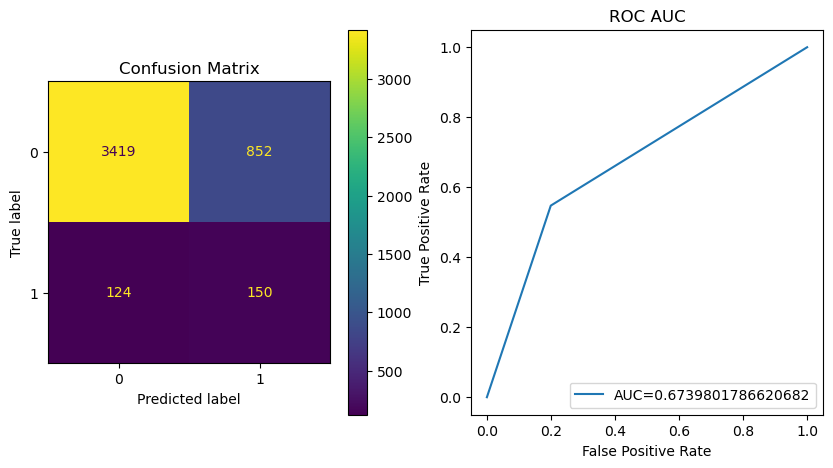

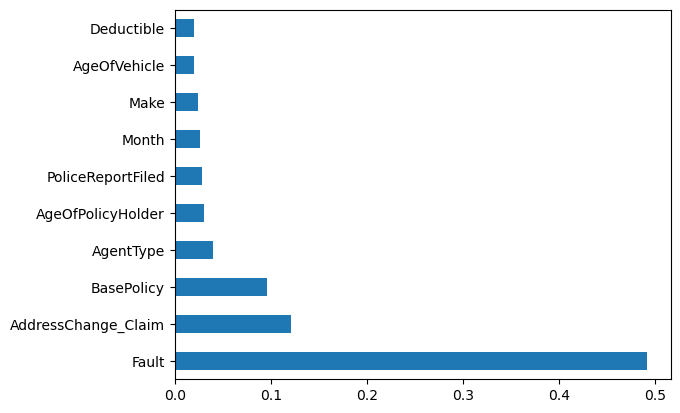

In [16]:
xgb = XGBClassifier(
    tree_method="hist", 
    enable_categorical="True", 
    max_cat_to_onehot=1,
    use_label_encoder=False, 
    objective= 'binary:logistic',
    eval_metric='auc'
)

params = {
    'max_depth':[7],        #[3, 5, 7],
    'min_child_weight':[1],  #[1, 3, 5],
    'learning_rate': [0.1],  #[0.1, 0.01, 0.001],
    'n_estimators': [500],   #[100, 500, 1000],
    'scale_pos_weight': [25]
}

#Gridsearch CV
skf = RepeatedStratifiedKFold(n_splits=2)
gs = GridSearchCV(xgb, param_grid=params, scoring='precision', cv=skf)
gs.fit(X_train, y_train)

# Predict the classes on the testing data
threshold = 0.05
y_pred_train = (gs.predict_proba(X_train)[:,1] > threshold).astype('int')
y_pred_test = (gs.predict_proba(X_test)[:,1] > threshold).astype('int')


#Predict the classes on the testing data
#y_pred_train = gs.predict(X_train)
#y_pred_test = gs.predict(X_test) 

# Calculate the accuracy score
accuracy_train_score = accuracy_score(y_train, y_pred_train)
accuracy_test_score = accuracy_score(y_test,y_pred_test)


# Print the scores
print('------------------------------------------------------------')
print(f"Train Score: {round(accuracy_train_score,4)}")
print(f"Test Score: {round(accuracy_test_score,4)}")
print('------------------------------------------------------------')
print(classification_report(y_test, y_pred_test))
print('------------------------------------------------------------')
print("Best parameters: ", gs.best_params_)
print('------------------------------------------------------------')
print("Best score: ", gs.best_score_)
    
ig, ax = plt.subplots(1,2, figsize=(10,5))
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[0])
ax[0].set_title('Confusion Matrix')

# ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_pred_test)
ax[1].plot(fpr,tpr, label="AUC="+str(auc))
ax[1].set_title('ROC AUC')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')
ax[1].legend(loc=4)
plt.show()
    
feat_importances = pd.Series(gs.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).head(10).plot(kind='barh');


In [17]:
dump(gs,'xgb_model.joblib')

['xgb_model.joblib']

In [22]:
df.loc[15412]

Month                            Nov
Make                           Mazda
AccidentArea                   Urban
Sex                             Male
Age                             40.0
Fault                  Policy Holder
VehicleCategory                Sport
FraudFound_P                       0
Deductible                       400
PastNumberOfClaims                 1
AgeOfPolicyHolder           36 to 40
PoliceReportFiled                Yes
AgentType                   External
NumberOfSuppliments           1 to 2
AddressChange_Claim        no change
BasePolicy                 Liability
AgeOfVehicle                 7 years
Name: 15412, dtype: object